In [80]:
import numpy as np
from matplotlib import pyplot as plt
import wrftools as wrf
from scipy import optimize
# import importlib
# importlib.reload(wrf)
plt.rcParams['figure.facecolor'] = 'white'

In [81]:
def fit_profs_r(P_wrf,r):
#     rx=r_full<rlim
#     r=r_full[rx]
#     P_wrf=P_wrf_full[rx]
    
    Pmin=min(P_wrf)
    Pe=1016
    Rm=130
    B=1
    lam=Rm
    def P_lam(args,r):
        lam=args[0]
        return(Pe-Pmin)*(1-np.exp(-(r**2)/(2*lam**2)))/(-r**2/(2*lam**2))+Pe

    def P_Gau(args,r):
        Rm=args[0]
        return(-(Pe-Pmin)*np.exp(-r**2/(2*Rm**2))+Pe)

    def P_Hol(args,r):
        Rm=args[0]
        B=1
        return(np.exp(-(Rm/r)**B)*(Pe-Pmin)+Pmin)

    def rmse(x,y):
        return(np.sqrt(np.mean((x-y)**2)))

    def fit_prof(fun,args0,r):
        res=optimize.minimize(fun,args0,r,method='POWELL')
        return({'args':res.x,'rmse':res.fun})
    def err_lam(args,r):
        return(rmse(P_lam(args,r),P_wrf))

    def err_Gau(args,r):
        return(rmse(P_Gau(args,r),P_wrf))

    def err_Hol(args,r):
        return(rmse(P_Hol(args,r),P_wrf))
#     rlim=100

    args_lam0=[lam]
    args_Gau0=[Rm]
    args_Hol0=[Rm,B]

    funs=[err_lam,err_Gau,err_Hol]
    args0s=[args_lam0,args_Gau0,args_Hol0]

    rmses=[]
    argss=[]
    for i in range(3):
#         fits.append(fit_prof(funs[i],args0s[i]))
        rmses.append(fit_prof(funs[i],args0s[i],r)['rmse'])
        argss.append(fit_prof(funs[i],args0s[i],r)['args'])


    return({'rmses':rmses,'argss':argss})

<ipython-input-81-6cce2a2b1bd1>:25: RuntimeWarning: overflow encountered in square
  return(np.sqrt(np.mean((x-y)**2)))


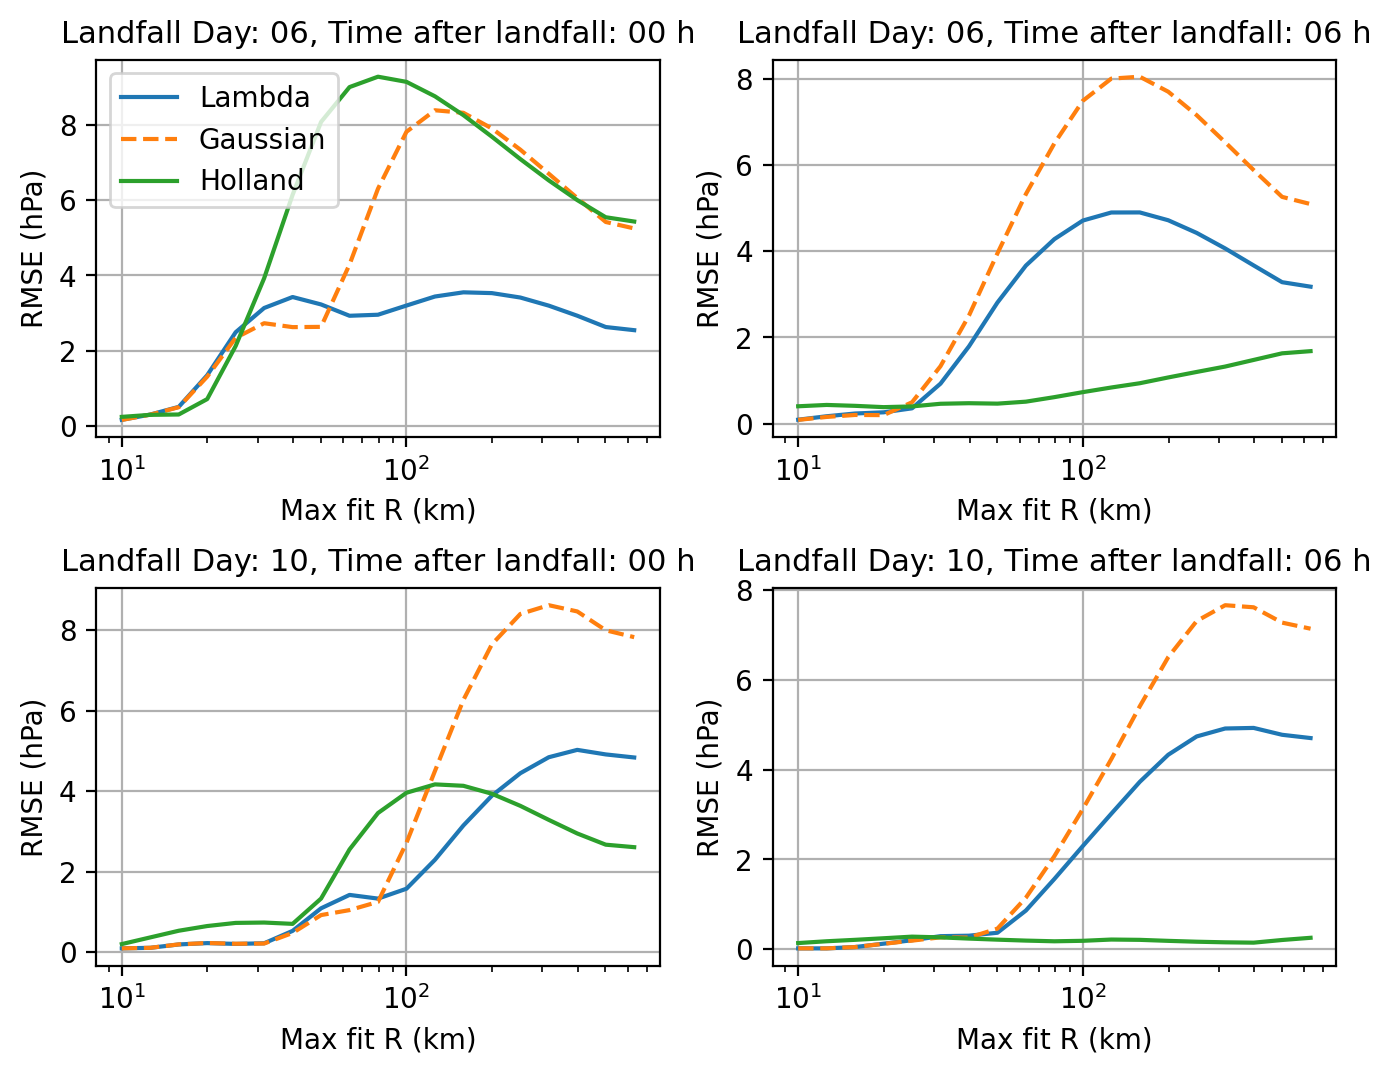

In [141]:
lfds=['06','10']
hrs=['00','06']

fig,axs=plt.subplots(len(lfds),len(hrs),figsize=(8,6),dpi=200)
plt.subplots_adjust(hspace=0.4)
for i,lfd in enumerate(lfds):
    for j,hr in enumerate(hrs):
        run='run_land_t' + lfd + '_rr'
        fname='wrfout_d03_2007-09-'+ lfd +'_'+ hr +':00:00'

        P_wrf=wrf.getWRF(run,fname,'P',z=0,vtype='az')
        r=wrf.getRcoord(wrf.wopath(run,fname))

        rlims=10**np.arange(1,2.9,0.1)
        rmses=[fit_profs_r(P_wrf[r<rlim],r[r<rlim])['rmses'] for rlim in rlims]

        rmses=list(zip(*rmses))

        
        ax=axs[i,j]
        ax.plot(rlims,rmses[0]);
        ax.plot(rlims,rmses[1],'--');
        ax.plot(rlims,rmses[2]);

        ax.set_xscale('log')
        ax.set_ylabel('RMSE (hPa)')
        ax.set_xlabel('Max fit R (km)')
        if i==0 and j==0: 
            ax.legend(('Lambda','Gaussian','Holland'))
        ax.grid(True)
        ax.set_title('Landfall Day: ' +lfd + ', Time after landfall: ' + hr + ' h',fontsize=11)

In [105]:
def plot_fits(ax,r,P_wrf):
    Pmin=min(P_wrf)
    Pe=1016
    Rm=130
    B=1
    lam=Rm
    def P_lam(args,r):
        lam=args[0]
        return(Pe-Pmin)*(1-np.exp(-(r**2)/(2*lam**2)))/(-r**2/(2*lam**2))+Pe

    def P_Gau(args,r):
        Rm=args[0]
        return(-(Pe-Pmin)*np.exp(-r**2/(2*Rm**2))+Pe)

    def P_Hol(args,r):
        Rm=args[0]
        B=1
        return(np.exp(-(Rm/r)**B)*(Pe-Pmin)+Pmin)


    rmses=[fit_profs_r(P_wrf,r)['rmses'] for rlim in rlims]
    argss=[fit_profs_r(P_wrf,r)['argss'] for rlim in rlims]

    args=argss[0]
    rmse=rmses[0]


    rx=r<rlims[0]
    ax.plot(r,P_lam(args[0],r))
    ax.plot(r,P_Gau(args[1],r),'--')
    ax.plot(r,P_Hol(args[2],r))
    ax.plot(r,P_wrf,':')
    ax.grid(True)
    if n==3 and m==0:
        ax.legend(('$\lambda$',
                   'G',
                   'H',
                    'W'),loc='lower right')
        
        
    textstr = '\n'.join((
    r'$\lambda=%.2f$' % (rmse[0], ),
    r'$G=%.2f$' % (rmse[1], ),
    r'$H=%.2f$' % (rmse[2], )))
    
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=11,
        verticalalignment='top')
    ax.set_xlabel('R (km)')
    ax.set_ylabel('P (hPa)')

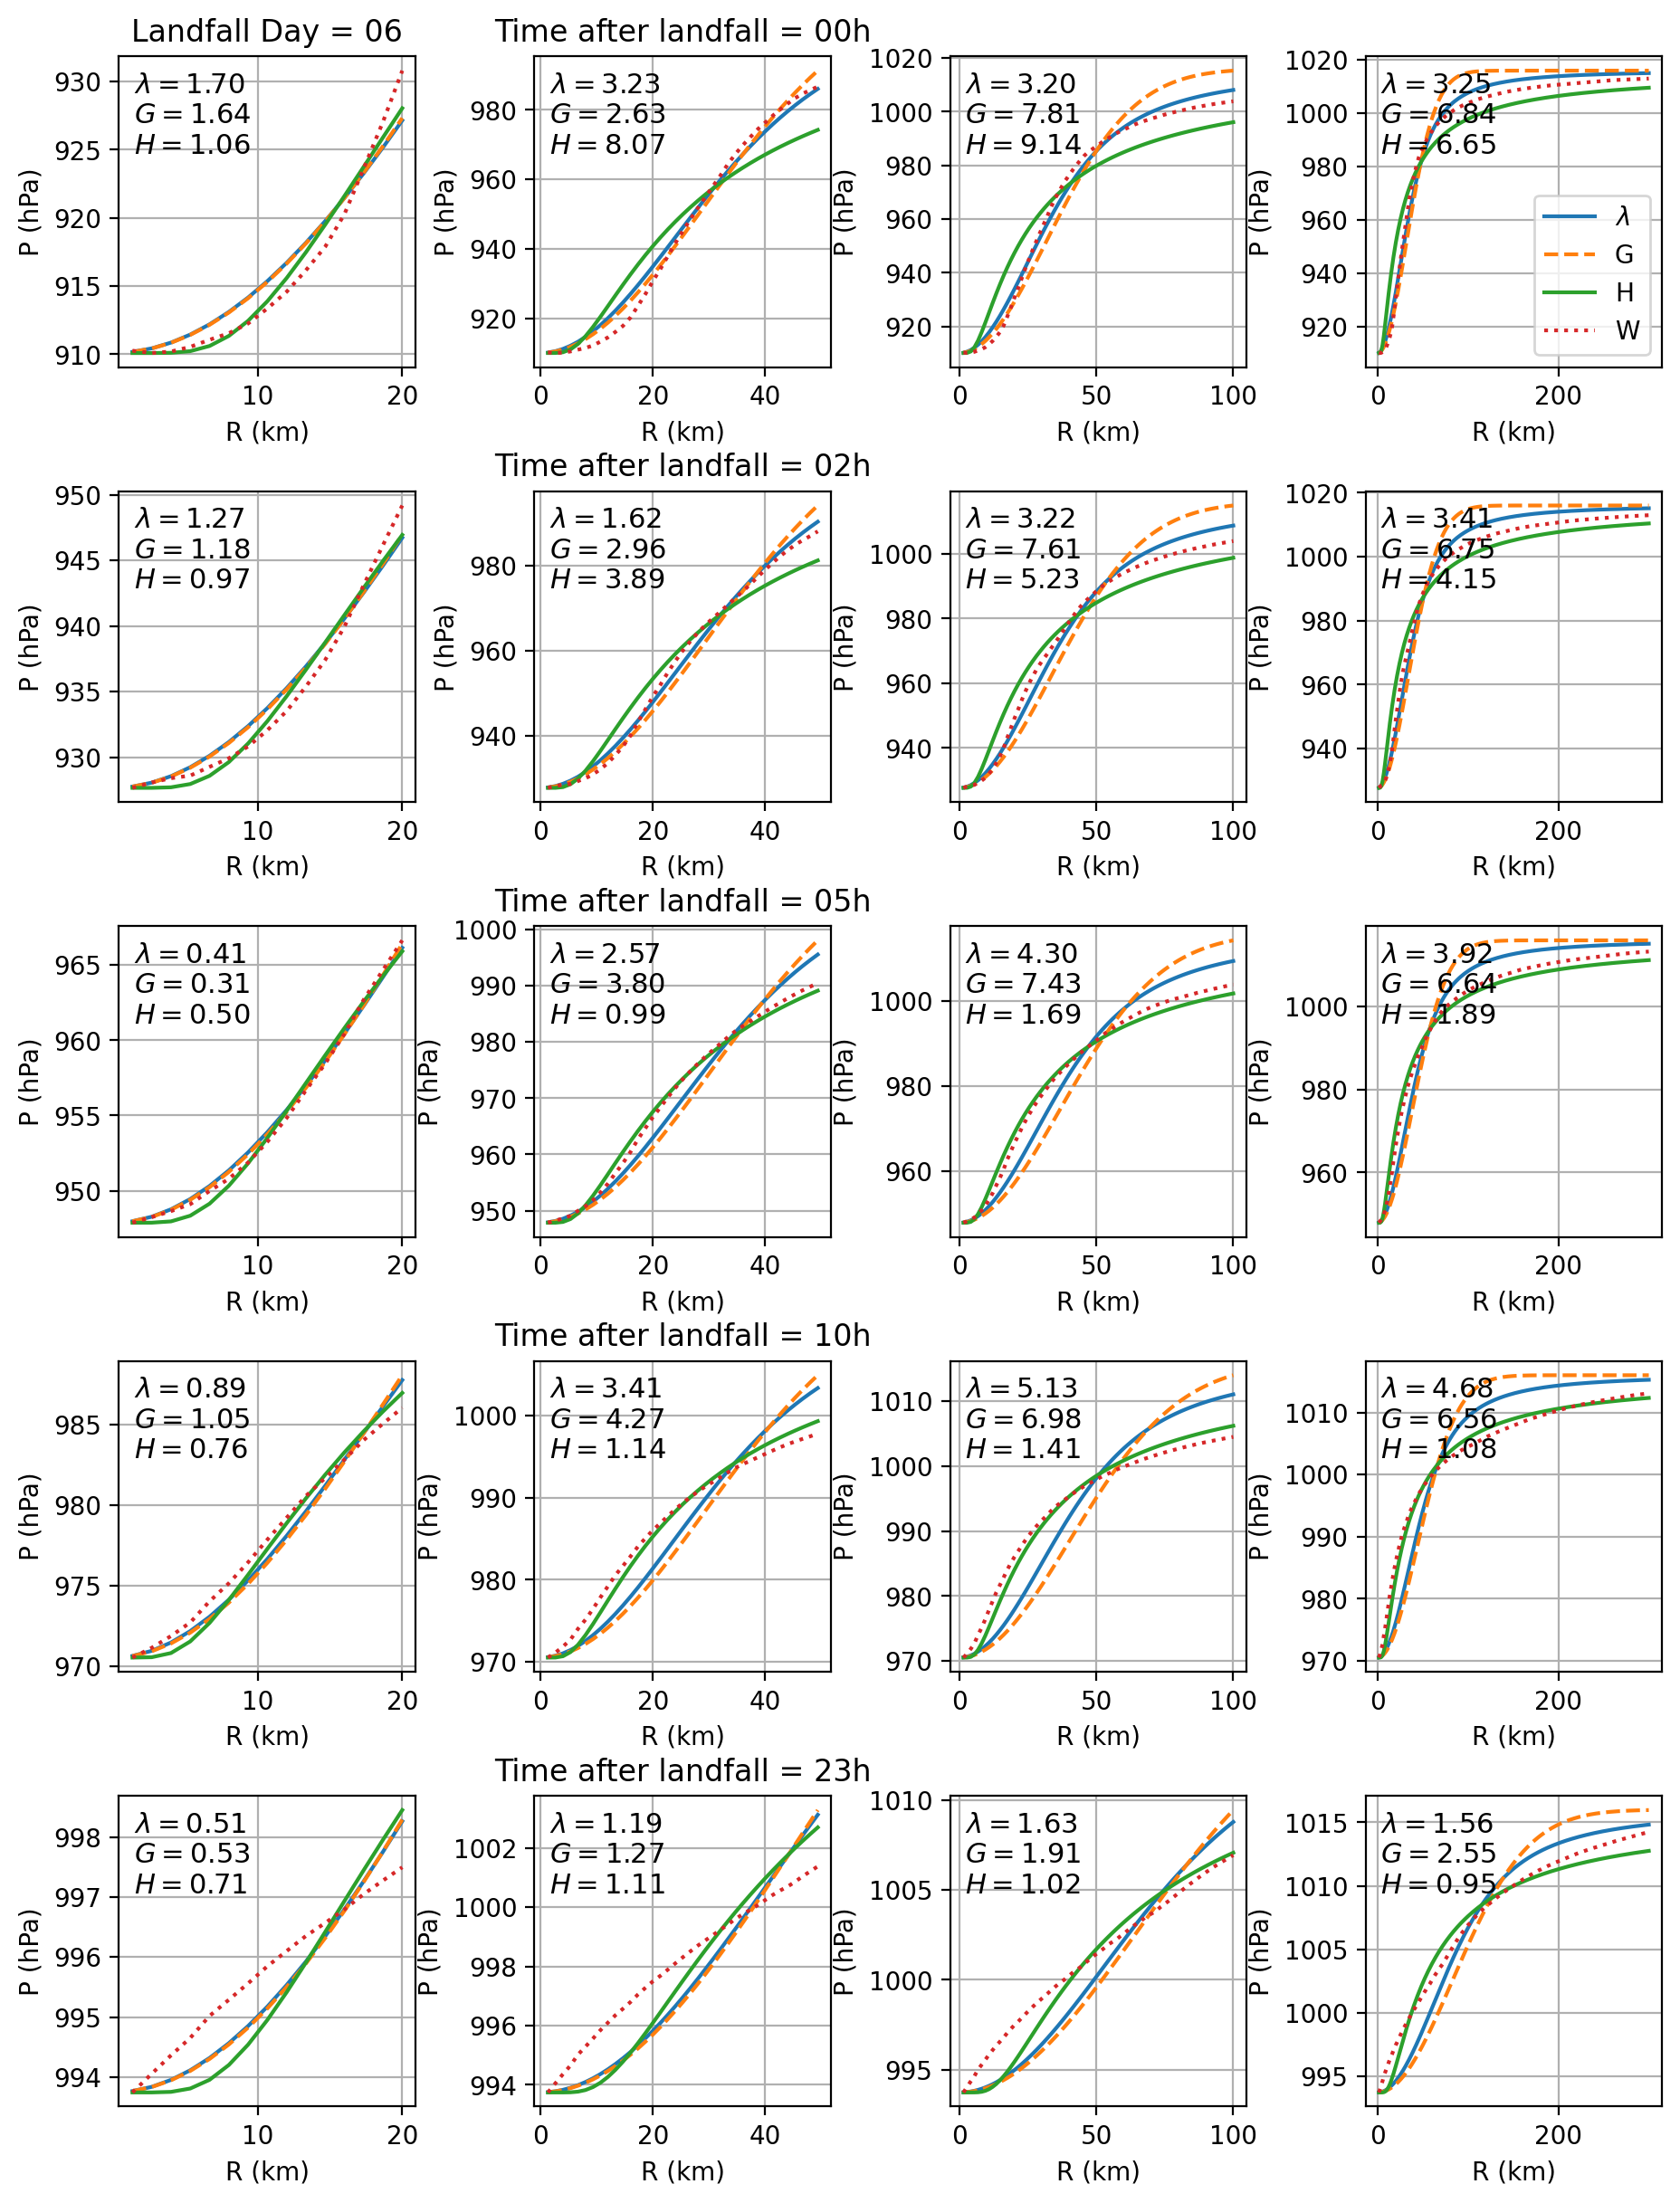

In [109]:
lfd='06'
run='run_land_t' + lfd + '_rr'
hrs=['00','02','05','10','23']
fnames=['wrfout_d03_2007-09-'+ lfd +'_'+ hr +':00:00' for hr in hrs]
rlims=[20,50,100,300]

fig, axs=plt.subplots(len(hrs),len(rlims),dpi=200,figsize=(11,15))
plt.subplots_adjust(wspace=0.4,hspace=0.4)

for m,fname in enumerate(fnames):
    P_wrf=wrf.getWRF(run,fname,'P',z=0,vtype='az')
    r=wrf.getRcoord(wrf.wopath(run,fname))
    for n,rlim in enumerate(rlims):
        plot_fits(axs[m,n],r[r<rlim],P_wrf[r<rlim])
        if n==1:
            axs[m,n].set_title('Time after landfall = ' + hrs[m] + 'h')
        if n==0 and m==0:
            axs[m,n].set_title('Landfall Day = ' + lfd)
            